### Roadmap
- Collect data into usable format
- show graphs
- some understanding of data > move to H testing
- interpret etc

This notebook mirrors the README but with a bit more detail

#### Data source
This data comes from public sources: 
- the LA metro bike share (https://bikeshare.metro.net/about/data/) 
- the Chicago divvy bike share (https://www.divvybikes.com/system-data)

Files can be downloaded as .zip and once unzipped are .csv. A couple Chicago files are not named .csv correctly and must be renamed manually before this script can interpret them correctly. This script does not download or unzip these files.

In [1]:
# Imports and dependencies. This EDA uses Spark

import pyspark as ps
from pyspark.sql.types import *
import pyspark.sql.functions as f
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

import bike_eda

# Most bike_eda.py functions use this spark session
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("morning sprint") 
        .getOrCreate()
        )

sc = spark.sparkContext

Below we can see the format of our data. There is some useful information in here! We'll only get to explore a couple things in this EDA.

In [5]:
# First we want to get the data from our csv files. Let's start with LA

la_sdf = bike_eda.la_csv_to_sdf(spark)

la_sdf.show(1)

+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
| trip_id|duration|         start_time|           end_time|start_station|start_lat| start_lon|end_station| end_lat|   end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
|94851140|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|  34.0358|-118.23317|       3082|34.04652|-118.23741|   6279|           30|            One Way|   Monthly Pass|
+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
only showing top 1 row



The only missing data is a chunk of lattitude and longitude coordinates and a small number of missing bike IDs. It's likely there are some stations that don't have that information for whatever reason. Because the rest of the row still has data and we aren't using geographic data, we won't worry about those rows.

In [9]:
# How much missing data is in each column

la_sdf.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in la_sdf.columns]).show()

+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|trip_id|duration|start_time|end_time|start_station|start_lat|start_lon|end_station|end_lat|end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|      0|       0|         0|       0|            0|    50254|    50254|          0|  24649|  24649|     11|            0|                  0|              0|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+



Now let's move on to a visualization so we can get a sense of the shape of the data. One graph that's easy to interpret is the number of rides taken each month for different years.

You can see 2018 and 2019 follow a pretty basic pattern but 2020 really falls flat after COVID starts to take it's hold and societal changes roll in.

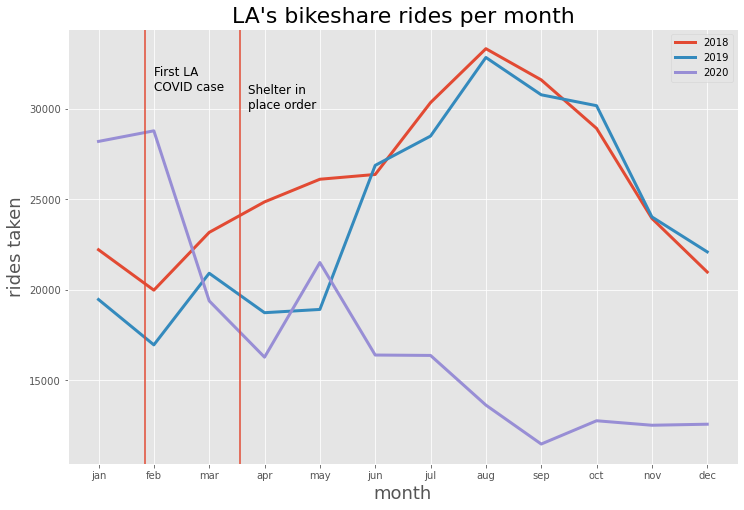

In [2]:
# Many of these cells take a minute to run, there is a lot of data to look through

fig, ax = plt.subplots(figsize=(12,8))

bike_eda.la_month_graph(spark, ax, hline=True)

In [2]:
# Now let's grab Chicago's data. First we gather it all into a Spark dataframe.

ch_sdf = bike_eda.ch_csv_to_sdf(spark)

ch_sdf.show(1)

+-------------------+-------------------+--------+
|         start_time|           end_time|usertype|
+-------------------+-------------------+--------+
|2019-04-01 00:02:22|2019-04-01 00:09:48|       1|
+-------------------+-------------------+--------+
only showing top 1 row

